In [5]:
from math import log,sqrt,exp
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.optimize import fsolve
import statsmodels.api as sm
from risklib import riskstats

## Problem1

In [2]:
# Initial assumptions
underlying =165
strike = 180
days = 14
dayyear = 365
rf = 0.0425
# dividend yield
q=0.0053

In [3]:
#ttm
ttm = days/dayyear

In [3]:
# generalized Black Scholes Merton
# rf = b       -- Black Scholes 1973
# b = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
# b = 0        -- Black 1976 futures option model
# b,r = 0      -- Asay 1982 margined futures option model
# b = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency
def gbsm(underlying,strike,ttm,rf,b,ivol,call=True):
    d1 = (log(underlying/strike)+(b+ivol**2/2)*ttm)/(ivol*sqrt(ttm))
    d2 = d1 - ivol*sqrt(ttm)
    if call:
        return underlying * exp((b-rf)*ttm) * norm(0,1).cdf(d1) - strike*exp(-rf*ttm)* norm(0,1).cdf(d2)
    else:
        return strike*exp(-rf*ttm)* norm(0,1).cdf(-d2) - underlying * exp((b-rf)*ttm) * norm(0,1).cdf(-d1)

In [5]:
# calculate for different volatility
vols = np.arange(0.1,0.8,0.01)
call_prices=[]
put_prices = []
for vol in vols:
    call_prices.append(gbsm(underlying,strike,ttm,rf,rf-q,vol,call=True))
    put_prices.append(gbsm(underlying,strike,ttm,rf,rf-q,vol,call=False))

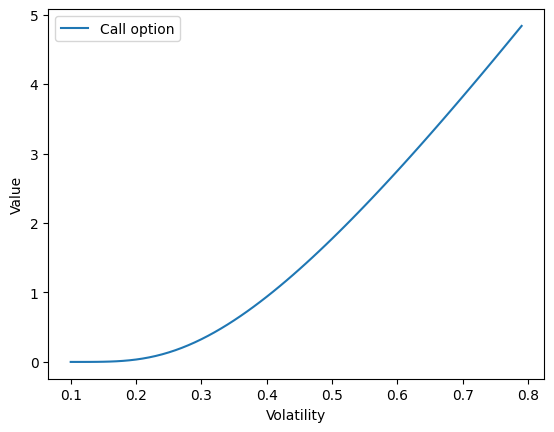

In [6]:
plt.plot(vols,call_prices,label="Call option")
plt.xlabel("Volatility")
plt.ylabel("Value")
plt.legend()

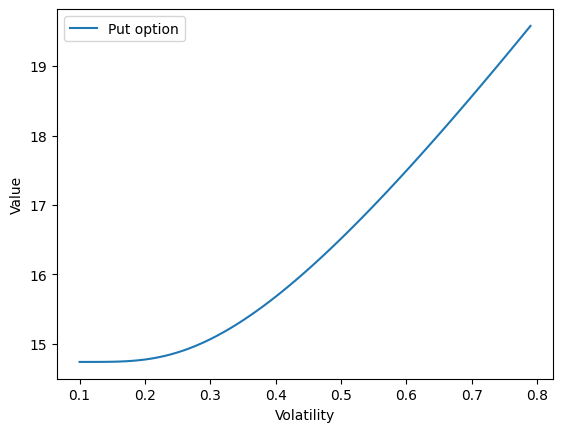

In [7]:
plt.plot(vols,put_prices,label="Put option")
plt.xlabel("Volatility")
plt.ylabel("Value")
plt.legend()

## Problem2

In [8]:
aapl_options = pd.read_csv("AAPL_Options.csv")

In [9]:
# Calculate ttm
curdate= datetime(2023,3,3)
aapl_options['Expiration']=aapl_options['Expiration'].astype("datetime64[ns]")
aapl_options['ttm'] = aapl_options['Expiration'].apply(lambda x: round((x-curdate).days/365,6))
aapl_options['Type'] = aapl_options['Type'].apply(lambda x: bool(x=="Call"))

In [1]:
# Solve Implied volatility using gbsm
def implied_vol(underlying,strike,ttm,rf,b,call,value,initvol):
    def sol_vol(x,underlying,strike,ttm,rf,b,call,value):
        return gbsm(underlying,strike,ttm,rf,b,x,call=call)-value
    vol = fsolve(sol_vol,initvol,args=(underlying,strike,ttm,rf,b,call,value))
    return vol[0]

In [2]:
# Initial assumptions
underlying =151.03
rf = 0.0425
# dividend yield
q=0.0053

In [12]:
# Apply the function to each option
def row_fun(row,underlying,rf,b):
    vol = implied_vol(underlying,row['Strike'],row['ttm'],rf,b,row['Type'],row['Last Price'],0.2)
    return vol
aapl_options['Implied Vol'] = aapl_options.apply(row_fun,args=(underlying,rf,round(rf-q,4)),axis=1)

In [13]:
print(aapl_options)

   Stock Expiration   Type  Strike  Last Price       ttm  Implied Vol
0   AAPL 2023-04-21   True     125      27.300  0.134247     0.374596
1   AAPL 2023-04-21   True     130      22.575  0.134247     0.342350
2   AAPL 2023-04-21   True     135      17.750  0.134247     0.292521
3   AAPL 2023-04-21   True     140      13.850  0.134247     0.299357
4   AAPL 2023-04-21   True     145       9.975  0.134247     0.278742
5   AAPL 2023-04-21   True     150       6.700  0.134247     0.263140
6   AAPL 2023-04-21   True     155       4.050  0.134247     0.246827
7   AAPL 2023-04-21   True     160       2.210  0.134247     0.235242
8   AAPL 2023-04-21   True     165       1.035  0.134247     0.223567
9   AAPL 2023-04-21   True     170       0.460  0.134247     0.219339
10  AAPL 2023-04-21   True     175       0.195  0.134247     0.218341
11  AAPL 2023-04-21  False     125       0.405  0.134247     0.334614
12  AAPL 2023-04-21  False     130       0.665  0.134247     0.314472
13  AAPL 2023-04-21 

In [14]:
aapl_call = aapl_options[aapl_options['Type']==True]
aapl_put = aapl_options[aapl_options['Type']==False]

Text(0.5, 0, 'Strike Price')

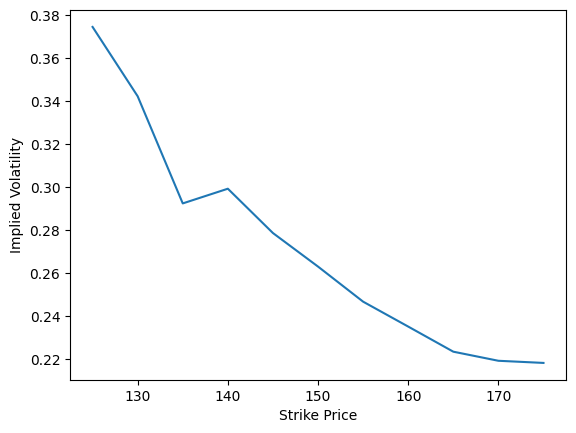

In [15]:
# Plot call options
plt.plot(aapl_call['Strike'],aapl_call['Implied Vol'])
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")

Text(0.5, 0, 'Strike Price')

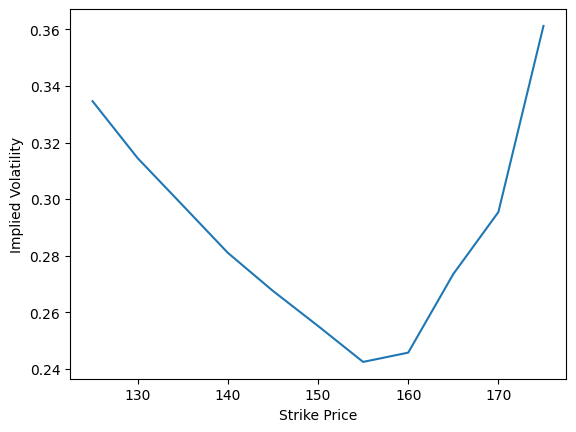

In [16]:
# Plot put options
plt.plot(aapl_put['Strike'],aapl_put['Implied Vol'])
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")

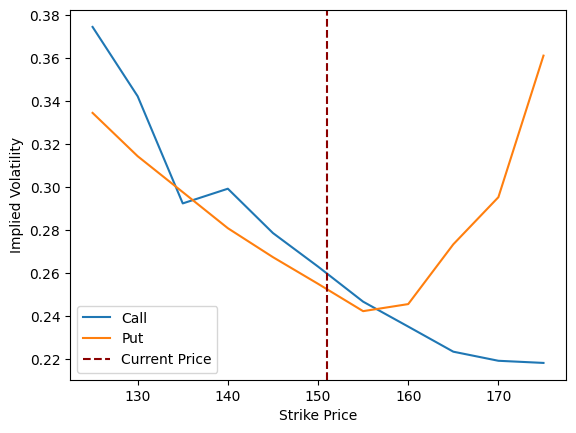

In [17]:
#Put together call and put
plt.plot(aapl_call['Strike'],aapl_call['Implied Vol'],label="Call")
plt.plot(aapl_put['Strike'],aapl_put['Implied Vol'],label="Put")
plt.axvline(underlying,color = "darkred",label="Current Price",linestyle="--")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")
plt.legend()

## Problem3

In [13]:
port_options = pd.read_csv("Problem3.csv")

In [14]:
# Calculate ttm
curdate= datetime(2023,3,3)
port_options['ExpirationDate']=port_options['ExpirationDate'].astype("datetime64[ns]")
port_options['ttm'] = port_options['ExpirationDate'].apply(lambda x: round((x-curdate).days/365,6))
port_options['OptionType'] = port_options['OptionType'].apply(lambda x: bool(x=="Call") if pd.notna(x) else x)

In [45]:
# Initial assumptions
underlying =151.03
rf = 0.0425
# dividend yield
q=0.0053

In [16]:
# Caculate implied vol
def row_fun_port(row,underlying,rf,b):
    vol = implied_vol(underlying,row['Strike'],row['ttm'],rf,b,row['OptionType'],row['CurrentPrice'],0.2)
    return vol
port_options['Implied Vol'] = port_options[port_options['Type']=='Option'].apply(row_fun_port,args=(underlying,rf,round(rf-q,4)),axis=1)

In [18]:
# Calculate value for each option given the underlying
def value_cal(row,underlying,rf,b,daysahead):
    if row['Type'] == 'Stock':
        return underlying
    else:
        return gbsm(underlying,row['Strike'],row['ttm']-daysahead/365,rf,b,row['Implied Vol'],row['OptionType'])*row['Holding']

In [33]:
# Set the range for underlying
underlying_list = np.linspace(100,200,num=21).tolist()

In [34]:
# Create the dataframe to store the portfolio values
port_values = pd.DataFrame(port_options['Portfolio'])

In [35]:
for underlying in underlying_list:
    port_values[underlying]=port_options.apply(value_cal,args=(underlying,rf,round(rf-q,4),0),axis=1)

In [36]:
# Portfolio values under the range
portfolio_range = port_values.groupby('Portfolio').sum().T

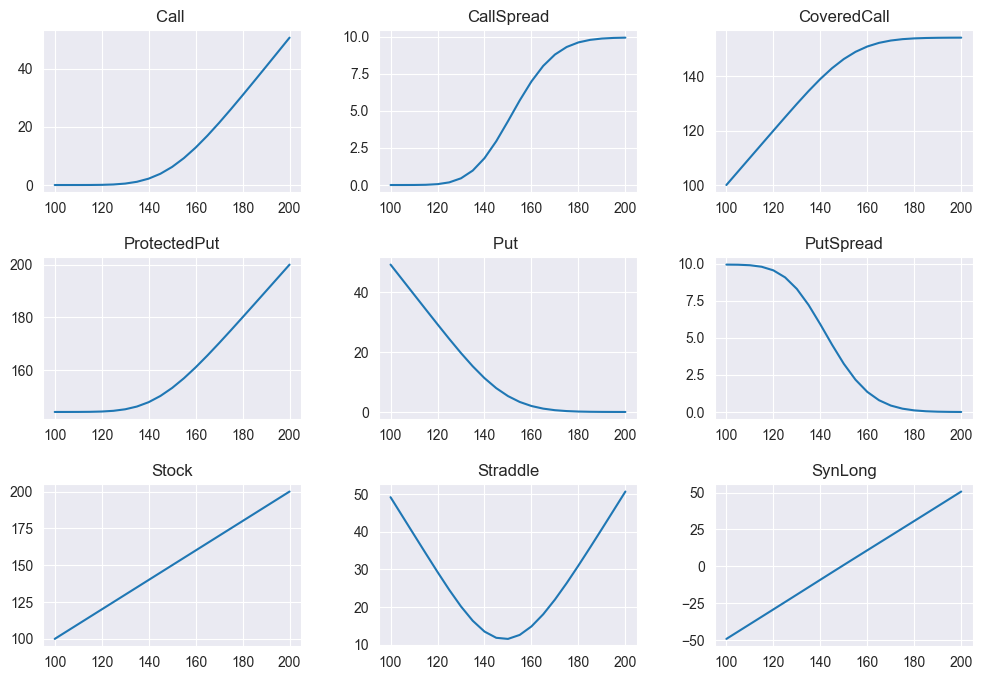

In [37]:
# Plot the shape for each portfolio
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(12,8))
for i in range(len(portfolio_range.columns)):
    x_ax = i // 3
    y_ax = i % 3
    port_name = portfolio_range.columns[i]
    axs[x_ax,y_ax].plot(portfolio_range.index,portfolio_range[port_name])
    axs[x_ax,y_ax].set_title(port_name)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

In [40]:
daily_prices = pd.read_csv("DailyPrices.csv")

In [41]:
# Calculate the log return of AAPL
aapl_log = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1))
# Demean the series
aapl_log = aapl_log-aapl_log.mean()

In [52]:
# Simulate using AR1
def ar1_sim(r,ndays,p0,nsim=10000,seed=10):
    ar1_fit = sm.tsa.arima.ARIMA(r, order=(1, 0, 0))
    con,beta,s= ar1_fit.fit().params[0],ar1_fit.fit().params[1],np.sqrt(ar1_fit.fit().params[2])
    np.random.seed(seed)
    rsim = np.zeros((nsim,ndays))
    for i in range(nsim):
        rsim[i,0] = con+ beta*r.iloc[-1] + s*np.random.normal()
        for j in range(1,ndays):
            rsim[i,j]=con+ beta*rsim[i,j-1] + s*np.random.normal()
    rsim_cum = np.sum(rsim,axis=1)
    psim = np.zeros(nsim)
    for i in range(nsim):
        psim[i]=p0*exp(rsim_cum[i])
    return psim

In [59]:
# simulated underlying price
underlying_sim = ar1_sim(aapl_log,10,underlying,seed=20)

In [60]:
# The current value of portfolios
port_current = port_options.apply(value_cal,args=(underlying,rf,round(rf-q,4),0),axis=1)
pl_list = []
for i in range(len(underlying_sim)):
    pl = port_options.apply(value_cal,args=(underlying_sim[i],rf,round(rf-q,4),10),axis=1) - port_current
    pl_list.append(pl)
pl_sim = pd.concat(pl_list,axis=1)

In [61]:
pl_sim.set_index(port_options['Portfolio'],inplace=True)
port_sim = pl_sim.groupby(level=0).sum().T

In [62]:
# calculate mean
port_mean = port_sim.mean(axis=0)
port_stat = pd.DataFrame(port_mean,columns=['Mean'])

In [63]:
# Calculate VaR and ES
vars = []
ess =[]
for col in port_sim.columns:
    vars.append(riskstats.VaR(port_sim[col].values))
    ess.append(riskstats.ES(port_sim[col].values))
port_stat['VaR'] = vars
port_stat['ES'] = ess

In [65]:
port_stat

,Mean,VaR,ES
Portfolio,,,
Call,1.038196,5.988252,6.347140
CallSpread,-0.001741,3.847345,4.167654
CoveredCall,-0.522999,11.838697,15.569207
ProtectedPut,1.160652,7.985268,8.652953
Put,0.643033,4.426451,4.618225
PutSpread,0.230375,2.675255,2.824306
Stock,0.599795,15.634519,19.493916
Straddle,1.681228,1.378967,1.387208
SynLong,0.395163,15.874334,19.757430
